In [2]:
!pip install import_ipynb
!pip install dtw-python

In [24]:
# Initial Setting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import import_ipynb
import Function
from dtw import *
from pykrx import stock
from sklearn.preprocessing import MinMaxScaler

In [4]:
kospi_200 = stock.get_index_portfolio_deposit_file("1028")

In [5]:
df = pd.DataFrame(columns=['시가', '고가', '저가', '종가', '거래량', '종목명', '종목코드'])
for i in kospi_200:
    tmp_df = stock.get_market_ohlcv_by_date("20200101", "20210101", i, "y")
    name = stock.get_market_ticker_name(i)
    tmp_df['종목명'] = name
    tmp_df['종목코드'] = i
    df = df.append(tmp_df)

거래량 순으로 정렬:

In [6]:
sorted_df = df.sort_values(by=['거래량'], axis=0, ascending = False)
print(sorted_df.head(30))
code_df = sorted_df.iloc[:30, 6]

                시가      고가     저가      종가           거래량      종목명    종목코드
2020-12-31   55500   81300  42300   81000  5.471749e+09     삼성전자  005930
2020-12-31    3305    7980   2920    4695  3.397658e+09    남선알미늄  008350
2020-12-31    7270    7930   3070    7040  2.263565e+09    삼성중공업  010140
2020-12-31    5550   10550   2500    7920  2.128066e+09  두산인프라코어  042670
2020-12-31    7330  214000      0  124000  2.036548e+09     신풍제약  019170
2020-12-31    2315    2870    881    2440  1.870908e+09     한화생명  088350
2020-12-31   23257   29713      0   18000  1.699525e+09   아시아나항공  020560
2020-12-31    5263   17700   2200   13500  1.497275e+09    두산중공업  034020
2020-12-31    6650   12800   3530    8040  1.351267e+09     영진약품  003520
2020-12-31    3555   15250   2120   13950  1.163048e+09      HMM  011200
2020-12-31   13112   42537  11285   28100  1.068908e+09     부광약품  003000
2020-12-31   96000  121000  65800  118500  1.027574e+09   SK하이닉스  000660
2020-12-31   28100   30050  15550   27400  9.467680

In [7]:
def volume_ret_df(date_1, date_2, date_3, date_4):
    code_list = []
    name_list = []
    f_list = []
    o_list = []
    p_list = []
    for i in range(len(code_df)):
        code_tmp = code_df[i]
        name_tmp = stock.get_market_ticker_name(code_tmp)
        volume_df = stock.get_market_trading_volume_by_date(date_1, date_2, code_tmp)
        code_list.append(code_tmp)
        name_list.append(name_tmp)
        f_list.append(volume_df['외국인합계'].sum())
        o_list.append(volume_df['기관합계'].sum())
        p_list.append(volume_df['개인'].sum())
    result_df = pd.DataFrame(columns=['종목코드', '종목명', '외국인거래량', '기관거래량', '개인거래량', '수익률'])
    result_df['종목코드'] = code_list
    result_df['종목명'] = name_list
    result_df['외국인거래량'] = f_list
    result_df['기관거래량'] = o_list
    result_df['개인거래량'] = p_list
    ret_list = []
    for i in range(len(code_df)):
        code_tmp = code_df[i]
        tmp_df = stock.get_market_ohlcv_by_date(date_3, date_4, code_tmp)
        ret_tmp = (tmp_df.iloc[4, 3] / tmp_df.iloc[0, 0] - 1) * 100
        ret_list.append(ret_tmp)
    result_df['수익률'] = ret_list
    return result_df

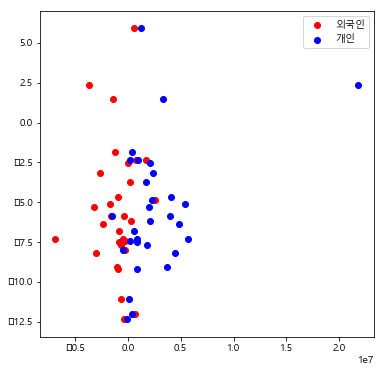

In [8]:
a_df = volume_ret_df("20200101", "20200131", "20200101", "20200131")
plt.figure(figsize = (6, 6))
plt.scatter(a_df['외국인거래량'], a_df['수익률'], c = 'r', label = '외국인')
plt.scatter(a_df['개인거래량'], a_df['수익률'], c = 'b', label = '개인')

plt.legend()
plt.show()

In [9]:
def linear_plot(date_1, date_2, code):
    new_df = stock.get_market_trading_volume_by_date(date_1, date_2, code)
    ret_list = []
    tmp_df = stock.get_market_ohlcv_by_date(date_1, date_2, code)
    for i in range(len(new_df)):
        ret_tmp = (tmp_df.iloc[i, 3] / tmp_df.iloc[i, 0] - 1) * 100
        ret_list.append(ret_tmp)
    new_df['수익률'] = ret_list
    dfPlot = new_df[::-1]

    for i in range(0,dfPlot.shape[1]):
        dfPlot.iloc[:,i] = (dfPlot.iloc[:,i]-np.min(dfPlot.iloc[:,i]))/(np.max(dfPlot.iloc[:,i])-np.min(dfPlot.iloc[:,i]))
    
    return new_df.index, dfPlot


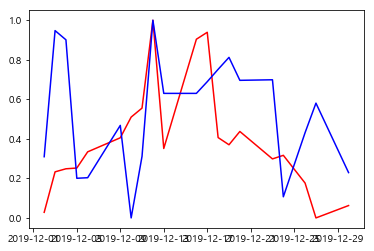

In [125]:
df_index, dfPlot = linear_plot("20191201", "20191231", "005930")

plt.plot(df_index, dfPlot['외국인합계'], c = 'r', label = '외국인')
plt.plot(df_index, dfPlot['수익률'], c = 'b', label = '수익률')

Total Distance :  4.657386468335586


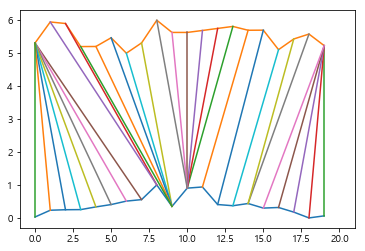

In [126]:
A = dfPlot['외국인합계'].to_numpy()
B = dfPlot['기관합계'].to_numpy()
C = dfPlot['개인'].to_numpy()
D = dfPlot['수익률'].to_numpy()
cost_fo, path_fo = Function.DTW(A, D, window = len(A))
print ('Total Distance : ', cost_fo)
offset = 5
plt.xlim([-1, max(len(A), len(D)) + 1])
plt.plot(A)
plt.plot(D + offset)
for(x1, x2) in path_fo:
    plt.plot([x1, x2], [A[x1], D[x2] + offset])
plt.show()

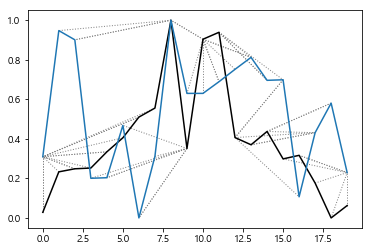

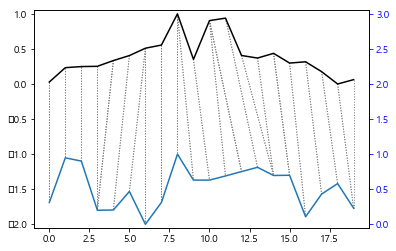

외국인 거래량과 주식 수익률 간의 Weight:  5.5153836756719965


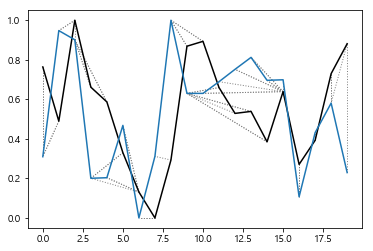

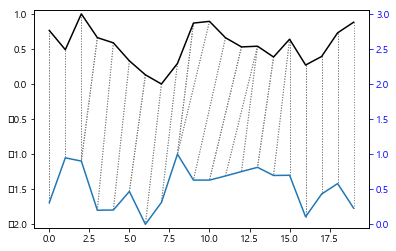

기관 거래량과 주식 수익률 간의 Weight:  5.160838880430735


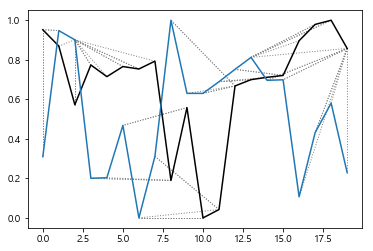

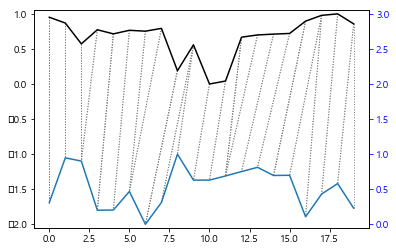

개인 거래량과 주식 수익률 간의 Weight:  6.085858221915354


In [130]:
dtw(A, D, keep_internals=True).plot(type="twoway")
dtw(A, D, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)
print("외국인 거래량과 주식 수익률 간의 Weight: ", dtw(A, D, keep_internals=True).distance)
dtw(B, D, keep_internals=True).plot(type="twoway")
dtw(B, D, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)
print("기관 거래량과 주식 수익률 간의 Weight: ", dtw(B, D, keep_internals=True).distance)
dtw(C, D, keep_internals=True).plot(type="twoway")
dtw(C, D, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)
print("개인 거래량과 주식 수익률 간의 Weight: ", dtw(C, D, keep_internals=True).distance)
